Phân tích biến động giá cổ phiếu VIC <br>
Người thực hiện: Đỗ Việt Bách <br>
Phone: 0559 686 243 <br>
Email: 19521230@gm.uit.edu.vn <br>
Dataset: Giá trị cổ phiếu VIC từ ngày 17/10/2018 tới ngày 22/12/2020 <br>
Mô hình dự báo: RNN vs. GRU

##Import dữ liệu và thư viện cần thiết

In [1]:
from google.colab import files
uploaded = files.upload()

Saving VIC.csv to VIC.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/VIC.csv')

In [4]:
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,10/17/2018 9:39,98.5,98.5,98.5,98.5,390,0
1,VIC,10/17/2018 9:40,98.5,98.5,98.5,98.5,760,0
2,VIC,10/17/2018 9:41,98.6,98.6,98.6,98.6,2060,0
3,VIC,10/17/2018 9:42,98.6,98.6,98.6,98.6,5540,0
4,VIC,10/17/2018 9:43,98.6,98.7,98.6,98.7,760,0
...,...,...,...,...,...,...,...,...
101261,VIC,12/22/2020 14:22,105.8,105.8,105.7,105.7,1870,0
101262,VIC,12/22/2020 14:23,105.7,105.7,105.7,105.7,2510,0
101263,VIC,12/22/2020 14:24,105.7,105.7,105.7,105.7,3620,0
101264,VIC,12/22/2020 14:25,105.7,105.7,105.7,105.7,100,0


##Làm sạch dữ liệu

In [5]:
# Xem kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         101266 non-null  object 
 1   Date/Time      101266 non-null  object 
 2   Open           101266 non-null  float64
 3   High           101266 non-null  float64
 4   Low            101266 non-null  float64
 5   Close          101266 non-null  float64
 6   Volume         101266 non-null  int64  
 7   Open Interest  101266 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 6.2+ MB


In [6]:
df.dtypes

Ticker            object
Date/Time         object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Open Interest      int64
dtype: object

In [7]:
# Kiểm tra hàng trùng lặp
df.duplicated().any()

False

In [8]:
# Kiểm tra Null
df.isnull().any()

Ticker           False
Date/Time        False
Open             False
High             False
Low              False
Close            False
Volume           False
Open Interest    False
dtype: bool

In [9]:
# Kiểm tra các giá trị min, max, mean(giá trị trung bình), standard(độ lệch chuẩn) của mỗi cột
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05,101266.0
mean,105.376460,105.418519,105.334147,105.378791,3.182640e+03,0.0
std,11.543158,11.535584,11.552338,11.545054,1.469814e+04,0.0
min,68.000000,68.000000,68.000000,68.000000,1.000000e+01,0.0
25%,95.400000,95.400000,95.300000,95.400000,2.300000e+02,0.0
50%,105.300000,105.300000,105.200000,105.300000,1.020000e+03,0.0
75%,115.800000,115.900000,115.800000,115.800000,3.000000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,1.468390e+06,0.0


In [10]:
import matplotlib.pyplot as plt

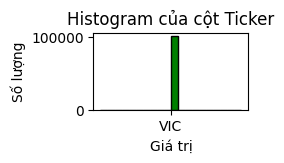

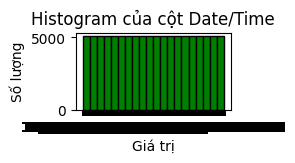

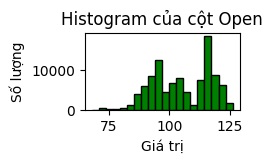

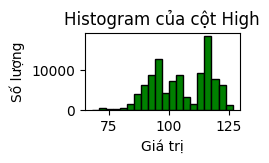

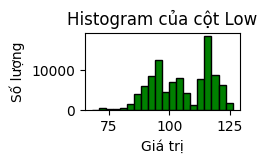

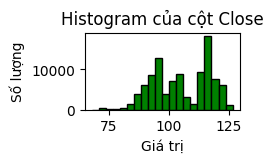

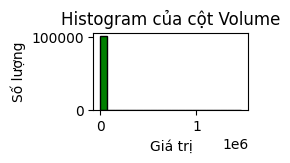

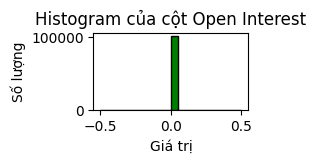

In [11]:
# Sử dụng Histogram để kiểm tra sự phân bổ giá trị trong mỗi cột
for column in df.columns:
    plt.figure(figsize=(2, 1))
    plt.hist(df[column], bins=20, color='green', edgecolor='black')
    plt.title(f'Histogram của cột {column}')
    plt.xlabel('Giá trị')
    plt.ylabel('Số lượng')
    plt.show()

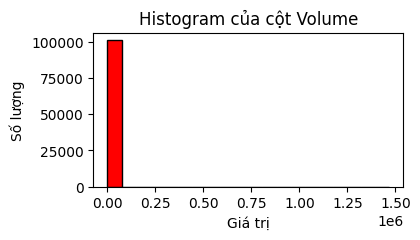

In [12]:
plt.figure(figsize=(4, 2))
plt.hist(df['Volume'], bins=20, color='red', edgecolor='black')
plt.title('Histogram của cột Volume')
plt.xlabel('Giá trị')
plt.ylabel('Số lượng')
plt.show()

### Nhận xét dữ liệu
+ Cột Volume có sự chênh lệch lớn giữa các giá trị, có thể làm dự báo sai lệch.
+ Ở đây bài toán đặt ra là dự báo giá trị cổ phiếu thì em sẽ sử dụng cột Close làm thuộc tính quyết định để dự báo. Do các cột Open, High, Low có sự tương đồng nên loại bỏ để giảm thời gian thực thi.
+ Để tăng Accuracy của thuật toán thì sẽ sử dụng Scale giá trị cột Close bằng công thức: (Giá trị - min)/(max - min)

In [13]:
df1 = df.reset_index()['Close']
df1 = df1.reset_index(drop=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Scale cột Close và lưu vào mảng
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
df1

array([[0.52136752],
       [0.52136752],
       [0.52307692],
       ...,
       [0.64444444],
       [0.64444444],
       [0.64444444]])

##Phân tích dữ liệu

### Phương pháp sử dụng
- Đề bài là phân tích biến động giá cổ phiếu, ở đây em lựa chọn giá cổ phiếu giờ đóng cửa (Close) để phân tích.
- Đối với tập dữ liệu này có 3 phương pháp phổ biến để phân tích:
  + 1.Phương pháp phân tích chuỗi thời gian (Time Series Analysis): ARIMA, SARIMA ...
  + 2.Phương pháp Machine Learning : Linear Regression, KNN ...
  + 3.Phương pháp Deep Learning
- Với bài toán dự báo xu hướng giá trị em sẽ sử dụng 2 mô hình Recurrent Neural Network (RNN) và mô hình Gated Recurrent Unit (GRU) nằm trong phương pháp Deep Learning. Trong phương pháp này mô hình Long short term memory (LSTM) có Accuracy tốt hơn, nhưng với tập dữ liệu có 101266 dòng thì LSTM có thời gian thực thi lâu hơn rất nhiều do sử dụng nhiều tham số.

In [18]:
# Chia dữ liệu thành 3 phần Train, Test, Validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
train_data

array([[0.52136752],
       [0.52136752],
       [0.52307692],
       ...,
       [0.4957265 ],
       [0.49401709],
       [0.5008547 ]])

In [20]:
test_data

array([[0.5008547 ],
       [0.5042735 ],
       [0.5042735 ],
       ...,
       [0.45299145],
       [0.44786325],
       [0.45299145]])

In [21]:
val_data

array([[0.45299145],
       [0.44786325],
       [0.44786325],
       ...,
       [0.64444444],
       [0.64444444],
       [0.64444444]])

### Mô hình RNN

In [22]:
# Gọi các thư viện cần thiết để xây dựng RNN
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [23]:
train_data_RNN = train_data
test_data_RNN = test_data
val_data_RNN = val_data

In [24]:
# Hàm Create Dataset để chuyển đổi mảng thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [25]:
# Sử dụng hàm Create Dataset để chuyển đổi các mảng Train, Test, Validate
time_step = 100
x_train_RNN, y_train_RNN = create_dataset(train_data_RNN, time_step)
x_val_RNN, y_val_RNN = create_dataset(val_data_RNN, time_step)
x_test_RNN, y_test_RNN = create_dataset(test_data_RNN, time_step)

In [26]:
# Reshape đầu vào để phù hợp với mô hình RNN
x_train_RNN = x_train_RNN.reshape(x_train_RNN.shape[0], x_train_RNN.shape[1], 1)
x_test_RNN = x_test_RNN.reshape(x_test_RNN.shape[0], x_test_RNN.shape[1], 1)
x_val_RNN = x_val_RNN.reshape(x_val_RNN.shape[0], x_val_RNN.shape[1], 1)

In [27]:
# Khai báo mô hình RNN
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
# Fit mô hình với dữ liệu Train
model.fit(x_train_RNN, y_train_RNN , validation_data = (x_test_RNN, y_test_RNN),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
1107/1107 [==============================] - 23s 19ms/step - loss: 0.0024 - val_loss: 3.7147e-05
Epoch 2/100
1107/1107 [==============================] - 21s 19ms/step - loss: 3.7859e-05 - val_loss: 9.3005e-05
Epoch 3/100
1107/1107 [==============================] - 23s 20ms/step - loss: 3.0099e-05 - val_loss: 2.0165e-05
Epoch 4/100
1107/1107 [==============================] - 20s 18ms/step - loss: 2.7439e-05 - val_loss: 6.7947e-05
Epoch 5/100
1107/1107 [==============================] - 21s 19ms/step - loss: 2.4123e-05 - val_loss: 3.4613e-05
Epoch 6/100
1107/1107 [==============================] - 21s 19ms/step - loss: 2.1977e-05 - val_loss: 1.3465e-05
Epoch 7/100
1107/1107 [==============================] - 20s 18ms/step - loss: 1.9095e-05 - val_loss: 2.6893e-05
Epoch 8/100
1107/1107 [==============================] - 21s 19ms/step - loss: 1.7168e-05 - val_loss: 3.5857e-05
Epoch 9/100
1107/1107 [==============================] - 21s 19ms/step - loss: 1.6248e-05 - val_loss

In [29]:
# Dự báo dữ liệu train_predict_RNN, y_pred_RNN, y_pred_val_RNN
train_predict_RNN = model.predict(x_train_RNN)
y_pred_RNN = model.predict(x_test_RNN)
y_pred_val_RNN = model.predict(x_val_RNN)

314/314 [==============================] - 2s 6ms/step


In [30]:
# Đảo ngược giá trị dự đoán trên tập Test và Validate về giá trị chuẩn
train_predict_RNN = scaler.inverse_transform(train_predict_RNN)
y_pred_RNN = scaler.inverse_transform(y_pred_RNN)
y_pred_val_RNN = scaler.inverse_transform(y_pred_val_RNN)

In [31]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
real_val_RNN = scaler.inverse_transform(y_val_RNN.reshape(-1, 1))
real_test_RNN = scaler.inverse_transform(y_test_RNN.reshape(-1, 1))

In [32]:
# Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse_RNN = np.sqrt(np.mean((y_pred_RNN - real_test_RNN)**2))
val_rmse_RNN = np.sqrt(np.mean((y_pred_val_RNN - real_val_RNN)**2))
print('Testing RMSE:', test_rmse_RNN)
print('Validation RMSE:', val_rmse_RNN)

Testing RMSE: 0.2031547403959164
Validation RMSE: 0.2233797713265392


In [33]:
# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape_RNN = np.mean((np.absolute(real_test_RNN - y_pred_RNN)/real_test_RNN)*100)
val_mape_RNN = np.mean((np.absolute(real_val_RNN - y_pred_val_RNN)/real_val_RNN)*100)
print('Testing MAPE:', test_mape_RNN)
print('Validation MAPE:', val_mape_RNN)

Testing MAPE: 0.14837381799600635
Validation MAPE: 0.13533726826281073


In [35]:
# Tính phần trăm độ chính xác trên tập Test và Validate
data_range_RNN = df['Close'].max() - df['Close'].min()
test_accuracy_RNN = (1 - test_rmse_RNN / data_range_RNN) * 100
val_accuracy_RNN = (1 - val_rmse_RNN / data_range_RNN) * 100
print('Testing Accuracy (%):', test_accuracy_RNN)
print('Validation Accuracy (%):', val_accuracy_RNN)

Testing Accuracy (%): 99.65272693949416
Validation Accuracy (%): 99.61815423704866


In [37]:
# Dự báo 15 stage tiếp theo
x_input_RNN = val_data_RNN[60:].reshape(1, -1)
x_input_RNN.shape

temp_input_RNN = list(x_input_RNN)
temp_input_RNN = temp_input_RNN[0].tolist()

lst_output_RNN = []
n_steps_RNN = 10066
i = 0
while i < 15:
    if len(temp_input_RNN) > 10066:
          x_input_RNN = np.array(temp_input_RNN[1:])
         #print("{} day input {}".format(i, x_input))
          x_input_RNN = x_input_RNN.reshape(1, -1)
          x_input_RNN = x_input_RNN.reshape((1, n_steps_RNN, 1))
          yhat = model.predict(x_input_RNN, verbose=0)
        #print("{} day output {}".format(i, yhat))
          temp_input_RNN.extend(yhat[0].tolist())
          temp_input_RNN = temp_input_RNN[1:]
          lst_output_RNN.extend(yhat.tolist())
          i = i + 1
    else:
        x_input_RNN = x_input_RNN.reshape((1, n_steps_RNN, 1))
        yhat = model.predict(x_input_RNN, verbose=0)

        temp_input_RNN.extend(yhat[0].tolist())

        lst_output_RNN.extend(yhat.tolist())
        i = i + 1

# Chuẩn hóa lại dự đoán 15 stage
predicted_values_RNN = np.array(lst_output_RNN)
predicted_values_RNN = predicted_values_RNN.reshape(-1, 1)

# Chuẩn hóa dự đoán
predicted_values_RNN = scaler.inverse_transform(predicted_values_RNN)

print("Dự đoán 15 stage tiếp theo:")
print(predicted_values_RNN)

Dự đoán 15 stage tiếp theo:
[[105.60871145]
 [105.54568624]
 [105.47898936]
 [105.40575111]
 [105.32978263]
 [105.25404081]
 [105.17601159]
 [105.09511268]
 [105.01295152]
 [104.92811245]
 [104.83980045]
 [104.750146  ]
 [104.65852845]
 [104.56457469]
 [104.468344  ]]


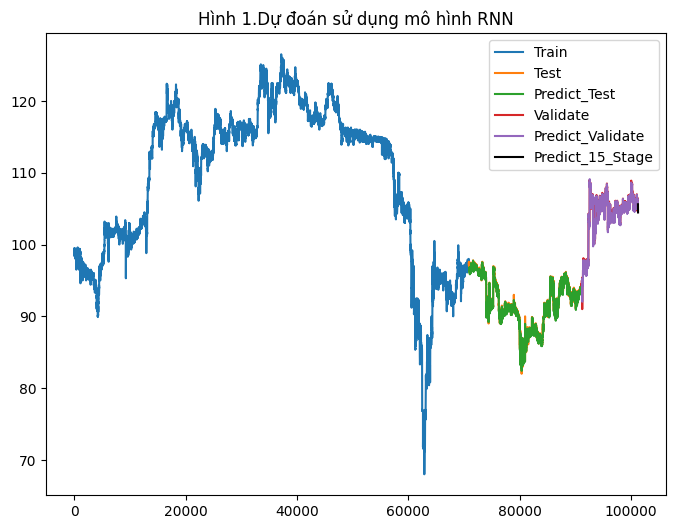

In [57]:
# Vẽ hình
plt.figure(figsize=(8, 6))
train_data_index_RNN = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data_RNN))
test_data_index_RNN = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index_RNN, scaler.inverse_transform(test_data_RNN))
test_data_index_RNN = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index_RNN,(y_pred_RNN))
val_data_index_RNN = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_RNN, scaler.inverse_transform(val_data_RNN))
val_data_index_RNN = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_RNN, y_pred_val_RNN)
predict_data_index_RNN = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_RNN, scaler.inverse_transform(lst_output_RNN), color='black')
plt.title('Hình 1.Dự đoán sử dụng mô hình RNN')
plt.legend(['Train','Test','Predict_Test','Validate','Predict_Validate','Predict_15_Stage'])
plt.show()

#### Nhận xét
- Kết quả dự báo 15 stage tiếp theo bằng mô hình RNN là pha giảm giá trị cổ phiếu.
- Độ chính xác của thuật toán dựa trên các thang đo RMSE và MAPE là rất cao.
- Độ chính xác của thuật toán để dự báo trên tập Test và Validate khoảng 99.6%.
- Nhìn trên ảnh ta thấy:
  + Kết quả dự báo trên tập Test (màu xanh) gần như trùng khớp với kết quả thực tế trên tập Test (màu vàng).
  + Kết quả dự báo trên tập Validate (màu tím) gần như trùng khớp với kết quả thực tế trên tập Validate (đỏ).
- Mô hình đang dự báo khá đúng với xu hướng giảm nhẹ của giá trị cổ phiếu, giảm 0.1 mỗi stage.


### Mô hình GRU

In [39]:
# Gọi các thư viện cần thiết để xây dựng RNN
from keras.models import Sequential
from keras.layers import Dense, GRU, BatchNormalization

In [40]:
train_data_GRU = train_data
test_data_GRU = test_data
val_data_GRU = val_data

In [41]:
# Hàm Create Dataset để chuyển đổi mảng thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [42]:
# Sử dụng hàm Create Dataset để chuyển đổi các mảng Train, Test, Validate
time_step = 100
x_train_GRU, y_train_GRU = create_dataset(train_data_GRU, time_step)
x_val_GRU, y_val_GRU = create_dataset(val_data_GRU, time_step)
x_test_GRU, y_test_GRU = create_dataset(test_data_GRU, time_step)

In [43]:
# Reshape đầu vào để phù hợp với mô hình GRU
x_train_GRU = x_train_GRU.reshape(x_train_GRU.shape[0], x_train_GRU.shape[1] , 1)
x_test_GRU = x_test_GRU.reshape(x_test_GRU.shape[0], x_test_GRU.shape[1] , 1)
x_val_GRU = x_val_GRU.reshape(x_val_GRU.shape[0], x_val_GRU.shape[1] , 1)

In [44]:
# Khai báo mô hình GRU
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# 9. Fit mô hình với dữ liệu Train
model.fit(x_train_GRU, y_train_GRU, validation_data = (x_test_GRU, y_test_GRU), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
1107/1107 [==============================] - 73s 63ms/step - loss: 0.0034 - val_loss: 1.1292e-05
Epoch 2/100
1107/1107 [==============================] - 66s 60ms/step - loss: 1.4001e-05 - val_loss: 1.5059e-05
Epoch 3/100
1107/1107 [==============================] - 66s 60ms/step - loss: 1.3207e-05 - val_loss: 9.8662e-06
Epoch 4/100
1107/1107 [==============================] - 56s 50ms/step - loss: 1.3503e-05 - val_loss: 2.0958e-05
Epoch 5/100
1107/1107 [==============================] - 56s 51ms/step - loss: 1.4476e-05 - val_loss: 1.0125e-05
Epoch 6/100
1107/1107 [==============================] - 55s 50ms/step - loss: 1.4576e-05 - val_loss: 1.6416e-05
Epoch 7/100
1107/1107 [==============================] - 55s 50ms/step - loss: 1.4682e-05 - val_loss: 4.1527e-05
Epoch 8/100
1107/1107 [==============================] - 57s 51ms/step - loss: 1.4277e-05 - val_loss: 3.7228e-05
Epoch 9/100
1107/1107 [==============================] - 56s 51ms/step - loss: 1.4248e-05 - val_loss

In [46]:
# Dự báo dữ liệu train_predict_GRU, y_pred_GRU, y_pred_val_GRU
train_predict_GRU = model.predict(x_train_GRU)
y_pred_GRU = model.predict(x_test_GRU)
y_pred_val_GRU = model.predict(x_val_GRU)

314/314 [==============================] - 3s 11ms/step


In [47]:
# Đảo ngược giá trị dự đoán trên tập Test và Validate về giá trị chuẩn
train_predict_GRU = scaler.inverse_transform(train_predict_GRU)
y_pred_GRU = scaler.inverse_transform(y_pred_GRU)
y_pred_val_GRU = scaler.inverse_transform(y_pred_val_GRU)

In [48]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
real_val_GRU = scaler.inverse_transform(y_val_GRU.reshape(-1, 1))
real_test_GRU = scaler.inverse_transform(y_test_GRU.reshape(-1, 1))

In [49]:
# Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse_GRU = np.sqrt(np.mean((y_pred_GRU - real_test_GRU)**2))
val_rmse_GRU = np.sqrt(np.mean((y_pred_val_GRU - real_val_GRU)**2))
print('Testing RMSE:', test_rmse_GRU)
print('Validation RMSE:', val_rmse_GRU)

Testing RMSE: 0.17953468409311615
Validation RMSE: 0.2056070161012773


In [50]:
# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape_GRU = np.mean((np.absolute(real_test_GRU - y_pred_GRU)/real_test_GRU)*100)
val_mape_GRU = np.mean((np.absolute(real_val_GRU - y_pred_val_GRU)/real_val_GRU)*100)
print('Testing MAPE:', test_mape_GRU)
print('Validation MAPE:', val_mape_GRU)

Testing MAPE: 0.10815876892061768
Validation MAPE: 0.10808050337076436


In [51]:
# Tính phần trăm độ chính xác trên tập Test và Validate
data_range_GRU = df['Close'].max() - df['Close'].min()
test_accuracy_GRU = (1 - test_rmse_GRU / data_range_GRU) * 100
val_accuracy_GRU = (1 - val_rmse_GRU / data_range_GRU) * 100
print('Testing Accuracy (%):', test_accuracy_GRU)
print('Validation Accuracy (%):', val_accuracy_GRU)

Testing Accuracy (%): 99.69310310411433
Validation Accuracy (%): 99.6485350152115


In [53]:
# Dự báo 15 stage tiếp theo
x_input_GRU = val_data_GRU[60:].reshape(1, -1)
x_input_GRU.shape

temp_input_GRU = list(x_input_GRU)
temp_input_GRU = temp_input_GRU[0].tolist()

lst_output_GRU = []
n_steps_GRU = 10067
i = 0
while i < 15:
    if len(temp_input_GRU) > 10067:
          x_input_GRU = np.array(temp_input_GRU[1:])

          x_input_GRU = x_input_GRU.reshape(1, -1)
          x_input_GRU = x_input_GRU.reshape((1, n_steps_GRU, 1))
          yhat = model.predict(x_input_GRU, verbose=0)

          temp_input_GRU.extend(yhat[0].tolist())
          temp_input_GRU = temp_input_GRU[1:]
          lst_output_GRU.extend(yhat.tolist())
          i = i + 1
    else:
        x_input_GRU = x_input_GRU.reshape((1, n_steps_GRU, 1))
        yhat = model.predict(x_input_GRU, verbose=0)

        temp_input_GRU.extend(yhat[0].tolist())

        lst_output_GRU.extend(yhat.tolist())
        i = i + 1

# Chuẩn hóa lại dự đoán 15 stage
predicted_values_GRU = np.array(lst_output_GRU)
predicted_values_GRU = predicted_values_GRU.reshape(-1, 1)

# Chuẩn hóa dự đoán
predicted_values_GRU = scaler.inverse_transform(predicted_values_GRU)

print("Dự đoán 15 stage tiếp theo:")
print(predicted_values_GRU)

Dự đoán 15 stage tiếp theo:
[[105.72688851]
 [105.74483892]
 [105.76375172]
 [105.78283536]
 [105.80196086]
 [105.82110029]
 [105.84020486]
 [105.85922924]
 [105.87812808]
 [105.8969014 ]
 [105.91555616]
 [105.93410981]
 [105.95256931]
 [105.97094163]
 [105.98923725]]


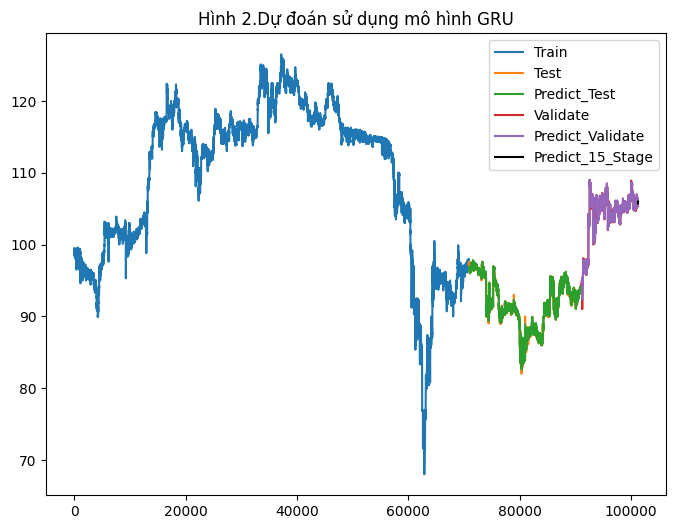

In [54]:
# Vẽ hình
plt.figure(figsize=(8, 6))
train_data_index_GRU = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data_GRU))
test_data_index_GRU = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index_GRU, scaler.inverse_transform(test_data_GRU))
test_data_index_GRU = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index_GRU, (y_pred_GRU))
val_data_index_GRU = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_GRU, scaler.inverse_transform(val_data_GRU))
val_data_index_GRU = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_GRU, y_pred_val_GRU)
predict_data_index_GRU = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_GRU, scaler.inverse_transform(lst_output_GRU), color='black')
plt.title('Hình 2.Dự đoán sử dụng mô hình GRU')
plt.legend(['Train','Test','Predict_Test','Validate','Predict_Validate','Predict_15_Stage'])
plt.show()

#### Nhận xét
- Kết quả dự báo 15 stage tiếp theo bằng mô hình GRU là pha tăng giá trị cổ phiếu.
- Độ chính xác của thuật toán dựa trên các thang đo RMSE và MAPE là rất cao.
- Độ chính xác của thuật toán để dự báo trên tập Test và Validate khoảng 99.6%.
- Nhìn trên ảnh ta thấy:
  + Kết quả dự báo trên tập Test (màu xanh) gần như trùng khớp với kết quả thực tế trên tập Test (màu vàng).
  + Kết quả dự báo trên tập Validate (màu tím) gần như trùng khớp với kết quả thực tế trên tập Validate (đỏ).
- Mô hình dự báo tăng không đáng kể 0.2 trong các stage tiếp theo. Điều này đi ngược với dự đoán của RNN và trông chưa thực sự phù hợp với xu hướng với các ngày gần nhất.

## Tổng kết

In [55]:
# So sánh 2 mô hình RNN và GRU
data = {
    'Độ đo': ['Test Accuracy (%)', 'Validation Accuracy (%)', 'Test RMSE', 'Validation RMSE', 'Test MAPE', 'Validation MAPE'],
    'Mô hình RNN': [test_accuracy_RNN, val_accuracy_RNN, test_rmse_RNN, val_rmse_RNN, test_mape_RNN, val_mape_RNN],
    'Mô hình GRU': [test_accuracy_GRU, val_accuracy_GRU, test_rmse_GRU, val_rmse_GRU, test_mape_GRU, val_mape_GRU]
}

df = pd.DataFrame(data).set_index('Độ đo')

print(df)

                         Mô hình RNN  Mô hình GRU
Độ đo                                            
Test Accuracy (%)          99.652727    99.693103
Validation Accuracy (%)    99.618154    99.648535
Test RMSE                   0.203155     0.179535
Validation RMSE             0.223380     0.205607
Test MAPE                   0.148374     0.108159
Validation MAPE             0.135337     0.108081


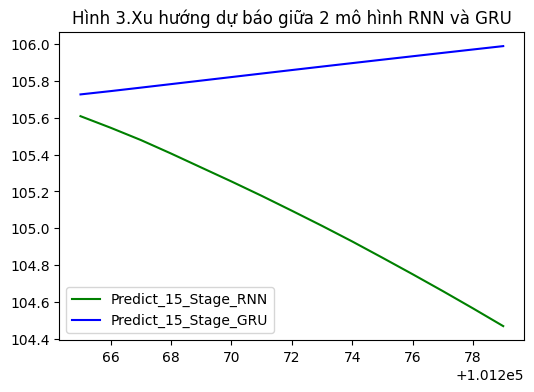

In [56]:
# Nhận xét Predict 15 stage của 2 mô hình
plt.figure(figsize=(6, 4))
predict_data_index_RNN = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_RNN, scaler.inverse_transform(lst_output_RNN), color='green')
predict_data_index_GRU = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_GRU, scaler.inverse_transform(lst_output_GRU), color='blue')
plt.title('Hình 3.Xu hướng dự báo giữa 2 mô hình RNN và GRU')
plt.legend(['Predict_15_Stage_RNN', 'Predict_15_Stage_GRU'])
plt.show()

### Tổng kết
- Nhìn ảnh so sánh trên, ta thấy cả 2 mô hình có kết quả rất khác nhau.
- Tuy nhìn vào số liệu của 10 stage gần nhất là pha giảm nhẹ như dự báo của RNN trong tương lai nhưng qua 2 dự báo trên chưa đáng tin cậy. Cần một mô hình mạnh mẽ hơn để giải quyết sự sai khác này.